In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix


#1. Upload The Dataset

In [5]:
!unzip "/content/csc462-connect-4.zip" -d "/content/"

Archive:  /content/csc462-connect-4.zip
  inflating: /content/sample_submission.csv  
  inflating: /content/test.csv       
  inflating: /content/train.csv      
  inflating: /content/val.csv        


In [6]:
testdata = pd.read_csv("/content/test.csv")
traindata = pd.read_csv("/content/train.csv")
valdata = pd.read_csv("/content/val.csv")

In [7]:
traindata.head()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p35,p36,p37,p38,p39,p40,p41,p42,turn,label_move_col
0,0,1,-1,1,-1,0,1,0,1,-1,...,0,0,0,0,0,0,0,0,1,1
1,0,-1,-1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,-1,1
2,0,1,-1,1,0,0,1,0,0,-1,...,0,0,0,0,0,0,0,0,-1,2
3,1,0,0,0,-1,1,1,-1,0,0,...,0,0,0,0,0,0,0,0,-1,3
4,1,1,-1,-1,-1,1,-1,1,0,0,...,1,-1,0,0,0,0,0,1,-1,4


In [8]:
traindata.shape

(49993, 44)

In [9]:
traindata['turn'].nunique()

2

#2. Preprocessing

## split

In [10]:
train_x = traindata.drop(columns=['label_move_col'])
train_x = train_x.replace({-1: 2})
train_y = traindata['label_move_col']
val_x = valdata.drop(columns=['label_move_col'])
val_x = val_x.replace({-1: 2})
val_y = valdata['label_move_col']
test_x = testdata.drop(columns=['id'])
test_x = test_x.replace({-1: 2})

In [11]:
traintensor_x = torch.tensor(train_x.values, dtype=torch.int64)
traintensor_y = torch.tensor(train_y.values, dtype=torch.long)
valtensor_x = torch.tensor(val_x.values, dtype=torch.int64)
valtensor_y = torch.tensor(val_y.values, dtype=torch.long)
testtensor_x = torch.tensor(test_x.values, dtype=torch.int64)


## convert to tensor and split

## build custom dataset class.
why? to handle preprocessing to transforms each game state into 2D representation, and to make sure the turn column is included within the state by adding it as extra channel. Also, this approach helps later in training process when loading the data to model for training.

In [12]:
def count_open(board, player):
    open_three_map = torch.zeros_like(board, dtype=torch.float32)
    open_two_map = torch.zeros_like(board, dtype=torch.float32)
    directions = [(0, 1),(1, 0),(1, 1),(-1, 1)]
    rows, cols = board.shape
    for dr, dc in directions:
        for r in range(rows):
            for c in range(cols):
                r_end = r + (3 * dr)
                c_end = c + (3 * dc)
                if not (0 <= r_end < rows and 0 <= c_end < cols):
                    continue
                cells = [board[r + i*dr, c + i*dc] for i in range(4)]
                cells_tensor = torch.tensor(cells)
                player_count = (cells_tensor == player).sum().item()
                empty_count = (cells_tensor == 0).sum().item()
                if player_count == 3 and empty_count == 1:
                    for i in range(4):
                        if cells[i] == 0:
                            rr = r + i*dr
                            cc = c + i*dc
                            open_three_map[rr, cc] = 1.0
                if player_count == 2 and empty_count == 2:
                    for i in range(4):
                        if cells[i] == 0:
                            rr = r + i*dr
                            cc = c + i*dc
                            open_two_map[rr, cc] = 1.0
    return open_two_map ,open_three_map

In [13]:
def precompute_open_features(X):

    N = X.shape[0]
    open2p_maps = torch.zeros((N, 6, 7), dtype=torch.float32)
    open3p_maps = torch.zeros((N, 6, 7), dtype=torch.float32)
    open2n_maps = torch.zeros((N, 6, 7), dtype=torch.float32)
    open3n_maps = torch.zeros((N, 6, 7), dtype=torch.float32)

    for i in range(N):
        row = X[i]
        board = row[:-1].view(6, 7)
        turn = row[-1].item()
        open2p_maps[i], open3p_maps[i] = count_open(board, turn)
        opponent = -turn
        open2n_maps[i], open3n_maps[i] = count_open(board, opponent)

    return open2p_maps, open3p_maps, open2n_maps, open3n_maps

In [14]:
class Connect4Dataset(Dataset):
    def __init__(self, X, y=None):

        self.X = torch.tensor(X, dtype=torch.int64)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        row = self.X[idx]


        board = row[:-1].view(6, 7)
        turn = row[-1].item() if row[-1].numel() == 1 else int(row[-1])

        #board_onehot = torch.nn.functional.one_hot(board, num_classes=3).float()
        #board_onehot = board_onehot.view(6,7,3).permute(2,0,1)
        #turn_channel = torch.full((1,6,7), float(turn.detach()), dtype=board_onehot.dtype)
        #board_with_turn = torch.cat([board_onehot, turn_channel], dim=0)
        player1 = (board == 1).float().unsqueeze(0)   # (1,6,7)
        player2 = (board == -1).float().unsqueeze(0)
        empty   = (board == 0).float().unsqueeze(0)

        open2p, open3p = count_open(board, turn) #count open opportunity for the current player
        open2n, open3n = count_open(board, -turn) #count open opportunity for the


        turn_channel = torch.full((1, 6, 7), 1.0 if turn == 1 else 0.0)
        board_input = torch.cat([player1, player2, empty, turn_channel], dim=0)



        if self.y is not None:
            label = self.y[idx]
            return board_input, label
        else:
            return board_input


In [15]:
class Connect4Dataset1(Dataset):
    def __init__(self, X, y=None, open2p=None, open3p=None, open2n=None, open3n=None):
        self.X = torch.tensor(X, dtype=torch.int64)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None
        self.open2p = open2p
        self.open3p = open3p
        self.open2n = open2n
        self.open3n = open3n

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        row = self.X[idx]
        board = row[:-1].view(6, 7)
        turn = row[-1].item() if row[-1].numel() == 1 else int(row[-1])
        normalized_board = (board + 1) / 2
        player1 = (board == 1).float().unsqueeze(0)
        player2 = (board == 0).float().unsqueeze(0)
        empty = (board == 0.5).float().unsqueeze(0)

        open2p = self.open2p[idx].unsqueeze(0)
        open3p = self.open3p[idx].unsqueeze(0)
        open2n = self.open2n[idx].unsqueeze(0)
        open3n = self.open3n[idx].unsqueeze(0)

        turn_channel = torch.full((1, 6, 7), 1.0 if turn == 1 else 0.0)

        board_input = torch.cat([player1, player2, empty, open2p, open3p, open2n, open3n, turn_channel], dim=0)

        if self.y is not None:
            label = self.y[idx]
            return board_input, label
        else:
            return board_input


#3. Load the dataset

In [16]:
def setup_dataset(X,y=None):
  open2p_maps, open3p_maps, open2n_maps, open3n_maps = precompute_open_features(X)
  dataset = Connect4Dataset1(X, y, open2p_maps, open3p_maps, open2n_maps, open3n_maps)
  return dataset


In [17]:
train_dataset = setup_dataset(traintensor_x, traintensor_y)
val_dataset = setup_dataset(valtensor_x, valtensor_y)
test_dataset = setup_dataset(testtensor_x)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/tmp/ipython-input-1859513733.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.int64)
/tmp/ipython-input-1859513733.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long) if y is not None else None


#4. Build the CNN model

Build the model architacture

In [18]:
class Connect4CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        self._to_linear = None
        self._d_forward()

        self.fc_layers = nn.Sequential(
            nn.Linear(self._to_linear, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 7)
        )

    def _d_forward(self):

        x = torch.zeros(1, 4, 6, 7)
        x = self.conv_layers(x)
        self._to_linear = x.numel()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [19]:
class Connect4CNN1(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(6, 42, kernel_size=4, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
        )

        self._to_linear = None
        self._get_flatten_size()

        self.fc_layers = nn.Sequential(
            nn.Linear(self._to_linear, 7),
        )

    def _get_flatten_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 6, 6, 7)
            x = self.conv_layers(x)
            self._to_linear = x.view(1, -1).size(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [20]:
class Connect4CNN2(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(8, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self._to_linear = None
        self._get_flatten_size()

        self.fc_layers = nn.Sequential(
            nn.Linear(self._to_linear, 64),
            nn.ReLU(),
            nn.Linear(64, 7),
        )

    def _get_flatten_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 8, 6, 7)
            x = self.conv_layers(x)
            self._to_linear = x.view(1, -1).size(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [28]:
class Connect4CNN3(nn.Module):
    def __init__(self):
        super().__init__()

        # --- Convolution Backbone ---
        self.conv1 = nn.Conv2d(8, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # Only one pooling → keeps spatial info (6×7 → 3×3)
        self.pool = nn.MaxPool2d(2)

        # --- Fully Connected Head ---
        # After convs: shape is (128, 3, 3)
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.drop1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.1)

        self.fc3 = nn.Linear(64, 7)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)   # 6×7 → 3×3, preserves structure

        x = torch.flatten(x, 1)

        x = self.drop1(F.relu(self.fc1(x)))
        x = self.drop2(F.relu(self.fc2(x)))

        return self.fc3(x)

In [56]:
class Connect4CNN4(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(8, 64, kernel_size=3, padding=1)
        self.gn1 = nn.GroupNorm(8, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.gn2 = nn.GroupNorm(16, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(128 * 1 * 1, 128)
        self.gn_fc1 = nn.GroupNorm(8, 128)
        self.drop1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(64, 7)

    def forward(self, x):
        x = self.pool1(F.relu(self.gn1(self.conv1(x))))
        x = self.pool2(F.relu(self.gn2(self.conv2(x))))

        x = torch.flatten(x, 1)

        x = self.drop1(F.relu(self.gn_fc1(self.fc1(x))))
        x = self.drop2(F.relu(self.fc2(x)))

        return self.fc3(x)

In [87]:
class Connect4CNN5(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(8, 64, kernel_size=3, padding=1)
        self.gn1 = nn.GroupNorm(8, 64)
        self.pool1 = nn.MaxPool2d(2)  # (6,7) -> (3,3)

        # Residual block layers
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.gn2_1 = nn.GroupNorm(16, 128)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.gn2_2 = nn.GroupNorm(16, 128)

        # 1x1 conv to match channels for residual connection
        self.skip_conv = nn.Conv2d(64, 128, kernel_size=1)
        self.skip_gn = nn.GroupNorm(16, 128)

        self.pool2 = nn.MaxPool2d(2)  # (3,3) -> (1,1)

        self.fc1 = nn.Linear(128 * 1 * 1, 128)
        self.gn_fc1 = nn.GroupNorm(8, 128)
        self.drop1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(64, 7)

    def residual_block(self, x):
        identity = self.skip_gn(self.skip_conv(x))  # match channels
        out = F.relu(self.gn2_1(self.conv2_1(x)))
        out = self.gn2_2(self.conv2_2(out))
        out += identity  # now shapes match
        return F.relu(out)

    def forward(self, x):
        x = self.pool1(F.relu(self.gn1(self.conv1(x))))  # (batch, 64, 3, 3)

        x = self.residual_block(x)  # (batch, 128, 3, 3)
        x = self.pool2(x)           # (batch, 128, 1, 1)

        x = torch.flatten(x, 1)
        x= self.drop_conv1 = nn.Dropout2d(0.3)
        x= self.drop_conv2 = nn.Dropout2d(0.3)

        return self.fc3(x)

In [ ]:

class ResidualBlock(nn.Module):
    def __init__(self, channels, dropout_prob=0.4):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(channels)
        self.dropout1 = nn.Dropout2d(dropout_prob)

        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(channels)
        self.dropout2 = nn.Dropout2d(dropout_prob)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout1(out)
        out = self.bn2(self.conv2(out))
        out = self.dropout2(out)
        return F.relu(out + identity)  # Skip Connection


class Connect4ResNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_in = nn.Conv2d(8, 64, kernel_size=3, padding=1)
        self.bn_in = nn.BatchNorm2d(64)
        self.dropout_in = nn.Dropout2d(0.3)

        self.res1 = ResidualBlock(64, dropout_prob=0.3)
        self.res2 = ResidualBlock(64, dropout_prob=0.3)
        self.res3 = ResidualBlock(64, dropout_prob=0.3)

        self.pool = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.dropout_fc1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 64)
        self.dropout_fc2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(64, 7)

    def forward(self, x):
        x = F.relu(self.bn_in(self.conv_in(x)))
        x = self.dropout_in(x)

        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)

        x = self.pool(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout_fc1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_fc2(x)

        return self.fc3(x)

# The used Model:

In [142]:

import random

class DropPath(nn.Module):
    def __init__(self, drop_prob=0.2):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if not self.training or self.drop_prob == 0.0:
            return x
        keep_prob = 1 - self.drop_prob
        # Generate binary mask to keep or drop entire samples
        mask = torch.empty((x.size(0), 1, 1, 1), device=x.device).bernoulli_(keep_prob)
        return x.div(keep_prob) * mask

class ResidualBlock1(nn.Module):
    def __init__(self, channels, dropout_prob=0.4, drop_path_prob=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(channels)
        self.dropout1 = nn.Dropout2d(dropout_prob)

        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(channels)
        self.dropout2 = nn.Dropout2d(dropout_prob)

        # BatchNorm after dropout for stability
        self.bn_after_dropout1 = nn.BatchNorm2d(channels)
        self.bn_after_dropout2 = nn.BatchNorm2d(channels)

        self.drop_path = DropPath(drop_path_prob)

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout1(out)
        out = self.bn_after_dropout1(out)

        out = self.bn2(self.conv2(out))
        out = self.dropout2(out)
        out = self.bn_after_dropout2(out)

        out = self.drop_path(out)  # stochastic depth applied here

        return F.relu(out + identity)  # Skip Connection


class Connect4ResNet1(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_in = nn.Conv2d(8, 64, kernel_size=3, padding=1)
        self.bn_in = nn.BatchNorm2d(64)
        self.dropout_in = nn.Dropout2d(0.3)

        self.res1 = ResidualBlock1(64, dropout_prob=0.3, drop_path_prob=0.1)
        self.res2 = ResidualBlock1(64, dropout_prob=0.3, drop_path_prob=0.2)
        self.res3 = ResidualBlock1(64, dropout_prob=0.3, drop_path_prob=0.3)

        self.pool = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.dropout_fc1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 64)
        self.dropout_fc2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(64, 7)

    def forward(self, x):
        x = F.relu(self.bn_in(self.conv_in(x)))
        x = self.dropout_in(x)

        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)

        x = self.pool(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout_fc1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_fc2(x)

        return self.fc3(x)


# 5. training setup

In [22]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [57]:
class LDAMLoss(nn.Module):
    def __init__(self, cls_num_list, max_m=0.5, weight=None, s=30):
        super().__init__()
        # Use cls_num_list directly, assuming it's already a tensor on the correct device
        m_list = 1.0 / torch.sqrt(torch.sqrt(cls_num_list))
        m_list = m_list * (max_m / m_list.max())
        # Explicitly ensure self.m_list is on the same device as cls_num_list
        self.m_list = m_list.to(cls_num_list.device)
        self.s = s
        self.weight = weight

    def forward(self, logits, target):
        index = torch.zeros_like(logits, dtype=torch.bool) # Changed to bool for scatter_ operation
        index.scatter_(1, target.data.view(-1,1), True)

        batch_m = torch.zeros_like(logits)
        # Ensure target is on the same device as self.m_list for indexing
        batch_m[index] = self.m_list[target.to(self.m_list.device)]

        adjusted_logits = logits - batch_m
        return F.cross_entropy(self.s * adjusted_logits, target, weight=self.weight)

In [42]:

from torch.optim.swa_utils import AveragedModel, SWALR

In [143]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_counts = torch.bincount(traintensor_y)
class_counts = class_counts.to(torch.float32)
total_samples = class_counts.sum()
num_classes = 7

class_weights = total_samples / (class_counts * num_classes)
weights = class_weights.to(device)

model = Connect4ResNet1().to(device)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

optimizer = torch.optim.AdamW(model.parameters(), lr=8e-4, weight_decay=1e-4)

num_epochs = 100
steps_per_epoch = len(train_loader)
total_steps = num_epochs * steps_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    pct_start=0.1,
    anneal_strategy='cos',
    div_factor=10,
    final_div_factor=100,
)


In [127]:
from torch.amp import GradScaler, autocast

In [144]:
best_val_loss = np.inf
patience = 10
counter = 0
best_model_path = "/content/best_connect4_model.pth"
train_losses = []
val_losses = []
val_accuracies = []
scaler =  GradScaler()
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        with autocast(device_type='cuda'):
            outputs = model(X)
            loss = criterion(outputs, y)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * X.size(0)
        scheduler.step()

    avg_train_loss = train_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            with autocast(device_type='cuda'):
                outputs = model(xb)
                loss = criterion(outputs, yb)
            val_loss += loss.item() * xb.size(0)

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

    if epoch in [99, 149]:
        torch.save(model.state_dict(), f"/content/{epoch+1}epoch_connect4_model.pth")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print("Validation loss improved — model saved.")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs.")
    if counter >= patience:
        print("Counter reached the patience limit. Stopping training.")
        break

Epoch [1/100] | Train Loss: 1.9956 | Val Loss: 1.9605 | Val Acc: 0.3519
Validation loss improved — model saved.
Epoch [2/100] | Train Loss: 1.9155 | Val Loss: 1.7498 | Val Acc: 0.4477
Validation loss improved — model saved.
Epoch [3/100] | Train Loss: 1.7840 | Val Loss: 1.6256 | Val Acc: 0.5143
Validation loss improved — model saved.
Epoch [4/100] | Train Loss: 1.7005 | Val Loss: 1.5415 | Val Acc: 0.5438
Validation loss improved — model saved.
Epoch [5/100] | Train Loss: 1.6540 | Val Loss: 1.4919 | Val Acc: 0.5659
Validation loss improved — model saved.
Epoch [6/100] | Train Loss: 1.6216 | Val Loss: 1.4549 | Val Acc: 0.5889
Validation loss improved — model saved.
Epoch [7/100] | Train Loss: 1.5874 | Val Loss: 1.4369 | Val Acc: 0.5923
Validation loss improved — model saved.
Epoch [8/100] | Train Loss: 1.5575 | Val Loss: 1.3999 | Val Acc: 0.6085
Validation loss improved — model saved.
Epoch [9/100] | Train Loss: 1.5344 | Val Loss: 1.3885 | Val Acc: 0.6085
Validation loss improved — model

In [160]:
model.load_state_dict(torch.load("/content/best_connect4_model.pth"))

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',        # Reduce LR when the monitored quantity (val loss) stops decreasing
    factor=0.5,        # LR reduction factor
    patience=5
)
additional_epochs = 50
total_epochs = 100 + additional_epochs

for epoch in range(additional_epochs):
    model.train()
    train_loss = 0.0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        with autocast(device_type='cuda'):
            outputs = model(X)
            loss = criterion(outputs, y)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * X.size(0)


    avg_train_loss = train_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            with autocast(device_type='cuda'):
                outputs = model(xb)
                loss = criterion(outputs, yb)
            val_loss += loss.item() * xb.size(0)

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)
    scheduler.step(avg_val_loss)


    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

    if epoch in [99, 149]:
        torch.save(model.state_dict(), f"/content/{epoch+1}epoch_connect4_model.pth")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print("Validation loss improved — model saved.")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs.")
    if counter >= patience:
        print("Counter reached the patience limit. Stopping training.")
        break

Epoch [1/100] | Train Loss: 1.2343 | Val Loss: 1.1915 | Val Acc: 0.6722
No improvement for 3 epochs.
Epoch [2/100] | Train Loss: 1.2304 | Val Loss: 1.1920 | Val Acc: 0.6722
No improvement for 4 epochs.
Epoch [3/100] | Train Loss: 1.2278 | Val Loss: 1.1899 | Val Acc: 0.6727
No improvement for 5 epochs.
Epoch [4/100] | Train Loss: 1.2252 | Val Loss: 1.1921 | Val Acc: 0.6714
No improvement for 6 epochs.
Epoch [5/100] | Train Loss: 1.2270 | Val Loss: 1.1912 | Val Acc: 0.6727
No improvement for 7 epochs.
Epoch [6/100] | Train Loss: 1.2288 | Val Loss: 1.1918 | Val Acc: 0.6735
No improvement for 8 epochs.
Epoch [7/100] | Train Loss: 1.2282 | Val Loss: 1.1943 | Val Acc: 0.6720
No improvement for 9 epochs.
Epoch [8/100] | Train Loss: 1.2290 | Val Loss: 1.1920 | Val Acc: 0.6721
No improvement for 10 epochs.
Counter reached the patience limit. Stopping training.


#Interpting the Model performance

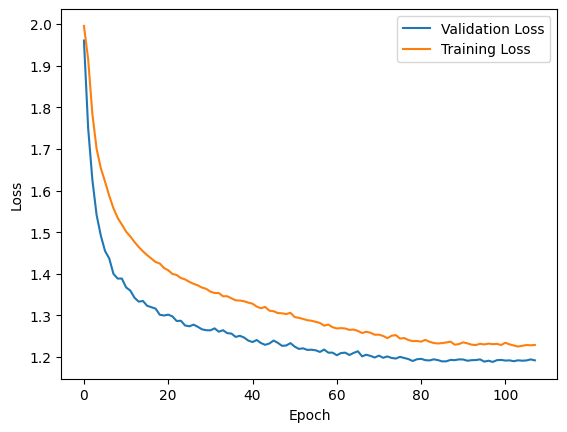

In [164]:
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

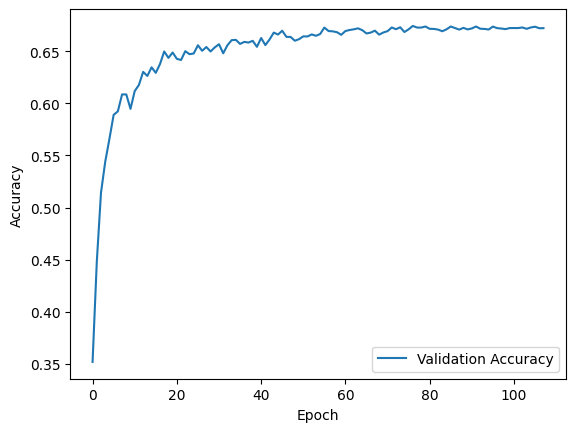

In [162]:
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Evaluation

In [166]:
best_model = Connect4ResNet1().to(device)
best_model.load_state_dict(torch.load("/content/best_connect4_model.pth"))
best_model.eval()

Connect4ResNet1(
  (conv_in): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_in): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_in): Dropout2d(p=0.3, inplace=False)
  (res1): ResidualBlock1(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.3, inplace=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.3, inplace=False)
    (bn_after_dropout1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn_after_dropout2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_path): DropPath()
  )
  (res2): ResidualBlock1(
    (conv1): Conv2d(64, 64, kernel_s

In [171]:
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        preds = torch.argmax(best_model(xb.to(device)), dim=1)
        y_true.extend(yb.numpy())
        y_pred.extend(preds.cpu().numpy())

report_dict = classification_report(y_true, y_pred, output_dict=True)

# Convert to pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()
report_df
#print(confusion_matrix(y_true, y_pred))

,precision,recall,f1-score,support
0,0.554331,0.485517,0.517647,1450.00000
1,0.560545,0.755676,0.643646,925.00000
2,0.623987,0.745402,0.679312,1033.00000
3,0.879433,0.720566,0.792112,3958.00000
4,0.624897,0.733785,0.674978,1033.00000
5,0.562349,0.755676,0.644834,925.00000
6,0.570242,0.520690,0.544340,1450.00000
accuracy,0.671710,0.671710,0.671710,0.67171
macro avg,0.625112,0.673902,0.642410,10774.00000
weighted avg,0.690570,0.671710,0.674391,10774.00000


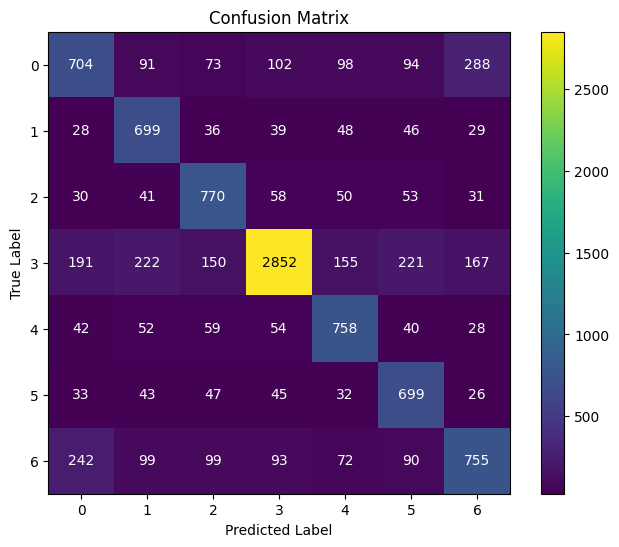

In [170]:
#confusion Matrix plt
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(7)
plt.xticks(tick_marks, np.arange(7))
plt.yticks(tick_marks, np.arange(7))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="black" if cm[i, j] > thresh else "white")

plt.show()

Save the model

In [172]:
torch.save(best_model.state_dict(), "connect4_final.pth")
traced = torch.jit.trace(best_model, torch.randn(1, 8, 6, 7).to(device))
traced.save("connect4_model_scripted.pt")